# Loading dependencies

In [1]:
###Reyes, Marcus Group 7

###CoE 197Z Project 1.1

import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,BatchNormalization
from keras import regularizers
from keras.optimizers import adam,sgd
from keras import optimizers

import numpy as np
from numpy import genfromtxt

from sklearn import preprocessing

import matplotlib.pyplot as plt

import string

from sixfunctions import load_train, load_x_test, clean_data_with_mean, recall_m,precision_m

print("Done importing")

Using TensorFlow backend.


Done importing


In [2]:
                  #[reason] / dup == duplicate
                  #unique      #dup of loc, numerous     #messy numerous
do_not_include = ['wpt_name', 'subvillage',             'scheme_name',

                 #uniform value     #Duplicate of payment type   #Dup of quantity
                 'recorded_by',     'payment',                  'quantity_group',
                 
                 #dup of wtptype less data      #dup of source  #dup of extr_type_class  #dup of extr_type_class
                 'waterpoint_type_group',       'source_type',  'extraction_type',      'extraction_type_group',
                 
                 #enc in regcode   #mostly zeroes    #dup of srctype
                 'region',         'amount_tsh',     'source']

#These are sort of ordinal data
do_not_one_hot = ['id','gps_height','date_recorded','longitude','latitude','population','construction_year']

clean_up = ['population','construction_year']

#Tentatively do not include.
do_not_include_tent = ['funder','installer','ward','lga']

#Don't know what it means 
do_not_include_temp = ['num_private']

x, train_col,y = load_train("train_set_values.csv","train_set_labels.csv", do_not_include, do_not_one_hot, clean_up, do_not_include_tent, do_not_include_temp)
uniqueValues, occurCount = np.unique(y, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)
print("Done loading data")

          id  amount_tsh date_recorded           funder  gps_height  \
0      69572      6000.0    2011-03-14            Roman        1390   
1       8776         0.0    2013-03-06          Grumeti        1399   
2      34310        25.0    2013-02-25     Lottery Club         686   
3      67743         0.0    2013-01-28           Unicef         263   
4      19728         0.0    2011-07-13      Action In A           0   
...      ...         ...           ...              ...         ...   
59395  60739        10.0    2013-05-03  Germany Republi        1210   
59396  27263      4700.0    2011-05-07      Cefa-njombe        1212   
59397  37057         0.0    2011-04-11              NaN           0   
59398  31282         0.0    2011-03-08            Malec           0   
59399  26348         0.0    2011-03-23       World Bank         191   

          installer  longitude   latitude              wpt_name  num_private  \
0             Roman  34.938093  -9.856322                  none    

      dtype='object') post
About to clean up
About to clean up


C:\Users\Marcus\197_proj1\CoE197Z\sixfunctions.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_recorded'][i] = int(data['date_recorded'][i].replace("-","")[2:6])


Expanded basin Change 21 30
Expanded region_code Change 30 57
Expanded district_code Change 57 77
Expanded public_meeting Change 77 79
Expanded scheme_management Change 79 91
Expanded permit Change 91 93
Expanded extraction_type_class Change 93 100
Expanded management Change 100 112
Expanded management_group Change 112 117
Expanded payment_type Change 117 124
Expanded water_quality Change 124 132
Expanded quality_group Change 132 138
Expanded quantity Change 138 143
Expanded source_class Change 143 146
Expanded waterpoint_type Change 146 153
Unique Values :  [0 1]
Occurrence Count :  [118800  59400]
Done loading data


In [3]:
print(y.shape)

(59400, 3)


In [6]:
###Model

hidden = 1024
dropout = 0.4

(trash, input_dim) = x.shape

activation = 'relu'

model = Sequential()


model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))

model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))


model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))


model.add(Dense(3,input_dim = hidden))
model.add(Activation('softmax'))

#model.summary
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])


max_score = -1
iter_of_max = 0,0
train_plot = []
val_plot = []
x_axis = []

#Save the weights for k-fold validation
model.save_weights('model.h5')

amount = 200
k_folds = 5

###When i use k_folds instead of 10 for the np.zeros initialization it acts up
val_plot = np.zeros((k_folds,amount))
train_plot = np.zeros((k_folds,amount))
test_plot = np.zeros((k_folds,amount)) 
x_axis = np.zeros((k_folds,amount))
total = int(x.shape[0])
print(total)
precision_plot0 = np.zeros((k_folds,amount))
recall_plot0 = np.zeros((k_folds,amount))

precision_plot1 = np.zeros((k_folds,amount))
recall_plot1 = np.zeros((k_folds,amount))

precision_plot2 = np.zeros((k_folds,amount))
recall_plot2 = np.zeros((k_folds,amount))

print("Done setting up for fitting")

59400
Done setting up for fitting


In [ ]:

for j in range(k_folds):

    whole = np.arange(0,total)
    test_range = np.arange((j)*(total/k_folds), (j)*(total/k_folds)+(total/k_folds),dtype = 'int')
    
    train_range = np.delete(whole, test_range)
    
    
    #K-fold validation setup
    x_train = x[train_range,:]
    x_pretest = x[test_range,:]
    y_train = y[train_range,:]
    y_pretest = y[test_range,:]
    print(test_range)
    print(train_range)
    
    for i in range(amount):

        history = model.fit(x_train, y_train, epochs = 1, batch_size = 4096*16, verbose = 0)
        score,accuracy = model.evaluate(x_pretest, y_pretest, batch_size = 512, verbose = 0)
        
        y_pred = model.predict(x_pretest)
        y_pred = np.argmax(y_pred, axis = 1)
        #y_pred = status.reshape(y_true.shape)
        y_true = np.argmax(y_pretest,axis = 1)
        precision0 = (precision_m(y_true,y_pred))
        recall0 = (recall_m(y_true, y_pred))
        if  float(100 * accuracy) > float(max_score):
            max_score = float(100 * accuracy)
            iter_of_max = i,j
        if i%1 == 0:
            print("----------",i,"-",j,"-----------")
            print("Test accuracy: ", (100.0 * accuracy))
            print("Maxscore: ", max_score, "at", iter_of_max,"epoch-kthfold")
        
        #for the plot
        x_axis[j,i] = i
        test_plot[j,i] = (accuracy)
        train_plot[j,i] = np.array(history.history['acc'])
        precision_plot0[j,i] = precision0[0]
        recall_plot0[j,i] = recall0[0]
        precision_plot1[j,i] = precision0[1]
        recall_plot1[j,i] = recall0[1]
        precision_plot2[j,i] = precision0[2]
        recall_plot2[j,i] = recall0[2]
        
        predictions = (y_pred == 0).sum(),(y_pred == 1).sum(),(y_pred == 2).sum()
        correct = (y_true == 0).sum(),(y_true == 1).sum(), (y_true == 2).sum()
        print(predictions, "Predictions")
        print(correct, "correct")
        #print(precision0[0],"Precision0")
        #print(recall0[0],"Recall0")

    if j == k_folds - 1:
        break
    model.load_weights('model.h5')
    print("Reloading Model")
    
print("Done evaluating performance")

[    0     1     2 ... 11877 11878 11879]
[11880 11881 11882 ... 59397 59398 59399]
---------- 0 - 0 -----------
Test accuracy:  54.141414133386576
Maxscore:  54.141414133386576 at (0, 0) epoch-kthfold
(11880, 0, 0) Predictions
(6432, 875, 4573) correct
---------- 1 - 0 -----------
Test accuracy:  66.67508418712552
Maxscore:  66.67508418712552 at (1, 0) epoch-kthfold
(7427, 0, 4453) Predictions
(6432, 875, 4573) correct
---------- 2 - 0 -----------
Test accuracy:  58.501683497669724
Maxscore:  66.67508418712552 at (1, 0) epoch-kthfold
(3792, 0, 8088) Predictions
(6432, 875, 4573) correct
---------- 3 - 0 -----------
Test accuracy:  66.1616161535886
Maxscore:  66.67508418712552 at (1, 0) epoch-kthfold
(9739, 0, 2141) Predictions
(6432, 875, 4573) correct
---------- 4 - 0 -----------
Test accuracy:  60.732323208240544
Maxscore:  66.67508418712552 at (1, 0) epoch-kthfold
(10974, 0, 906) Predictions
(6432, 875, 4573) correct
---------- 5 - 0 -----------
Test accuracy:  60.732323208240544
M

---------- 48 - 0 -----------
Test accuracy:  75.65656565656566
Maxscore:  75.65656565656566 at (48, 0) epoch-kthfold
(7909, 173, 3798) Predictions
(6432, 875, 4573) correct
---------- 49 - 0 -----------
Test accuracy:  75.69023567016679
Maxscore:  75.69023567016679 at (49, 0) epoch-kthfold
(7756, 214, 3910) Predictions
(6432, 875, 4573) correct
---------- 50 - 0 -----------
Test accuracy:  75.85016833009945
Maxscore:  75.85016833009945 at (50, 0) epoch-kthfold
(7811, 241, 3828) Predictions
(6432, 875, 4573) correct
---------- 51 - 0 -----------
Test accuracy:  75.81649829642942
Maxscore:  75.85016833009945 at (50, 0) epoch-kthfold
(7850, 240, 3790) Predictions
(6432, 875, 4573) correct
---------- 52 - 0 -----------
Test accuracy:  75.88383838383838
Maxscore:  75.88383838383838 at (52, 0) epoch-kthfold
(7867, 240, 3773) Predictions
(6432, 875, 4573) correct
---------- 53 - 0 -----------
Test accuracy:  75.95117845117845
Maxscore:  75.95117845117845 at (53, 0) epoch-kthfold
(7778, 242, 

---------- 96 - 0 -----------
Test accuracy:  77.46632994626106
Maxscore:  77.52525253729387 at (93, 0) epoch-kthfold
(7622, 464, 3794) Predictions
(6432, 875, 4573) correct
---------- 97 - 0 -----------
Test accuracy:  77.5084174883486
Maxscore:  77.52525253729387 at (93, 0) epoch-kthfold
(7514, 465, 3901) Predictions
(6432, 875, 4573) correct
---------- 98 - 0 -----------
Test accuracy:  77.54208755412888
Maxscore:  77.54208755412888 at (98, 0) epoch-kthfold
(7492, 455, 3933) Predictions
(6432, 875, 4573) correct
---------- 99 - 0 -----------
Test accuracy:  77.42424240417351
Maxscore:  77.54208755412888 at (98, 0) epoch-kthfold
(7629, 456, 3795) Predictions
(6432, 875, 4573) correct
---------- 100 - 0 -----------
Test accuracy:  77.34006735210869
Maxscore:  77.54208755412888 at (98, 0) epoch-kthfold
(7429, 463, 3988) Predictions
(6432, 875, 4573) correct
---------- 101 - 0 -----------
Test accuracy:  77.34006731999844
Maxscore:  77.54208755412888 at (98, 0) epoch-kthfold
(7545, 462,

---------- 143 - 0 -----------
Test accuracy:  77.52525250518362
Maxscore:  77.72727271924516 at (137, 0) epoch-kthfold
(7382, 529, 3969) Predictions
(6432, 875, 4573) correct
---------- 144 - 0 -----------
Test accuracy:  77.4074073873385
Maxscore:  77.72727271924516 at (137, 0) epoch-kthfold
(7303, 530, 4047) Predictions
(6432, 875, 4573) correct
---------- 145 - 0 -----------
Test accuracy:  77.74410773608018
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(7563, 501, 3816) Predictions
(6432, 875, 4573) correct
---------- 146 - 0 -----------
Test accuracy:  77.38215486208598
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(7353, 515, 4012) Predictions
(6432, 875, 4573) correct
---------- 147 - 0 -----------
Test accuracy:  77.64309763507008
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(7474, 520, 3886) Predictions
(6432, 875, 4573) correct
---------- 148 - 0 -----------
Test accuracy:  77.62626263830397
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(

---------- 190 - 0 -----------
Test accuracy:  77.16329967534101
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(7353, 533, 3994) Predictions
(6432, 875, 4573) correct
---------- 191 - 0 -----------
Test accuracy:  77.11279462483596
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(7317, 519, 4044) Predictions
(6432, 875, 4573) correct
---------- 192 - 0 -----------
Test accuracy:  77.02020203224336
Maxscore:  77.74410773608018 at (145, 0) epoch-kthfold
(7276, 537, 4067) Predictions
(6432, 875, 4573) correct


# Plotting the Training Accuracy vs the Test Accuracy

Test and Training Accuracy
Precision and Recall for 


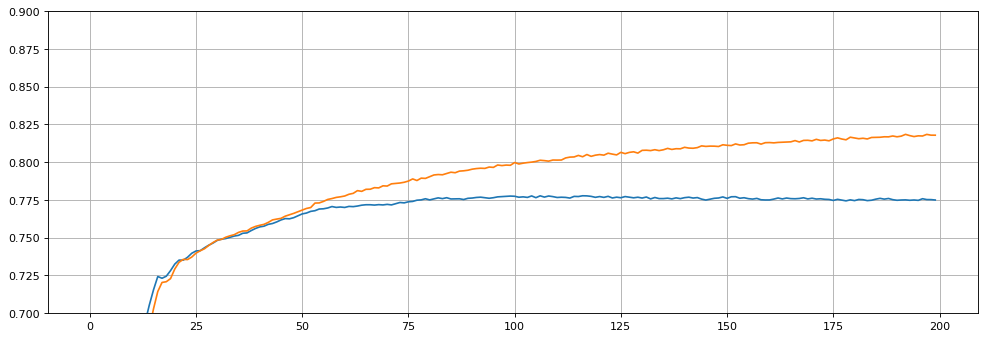

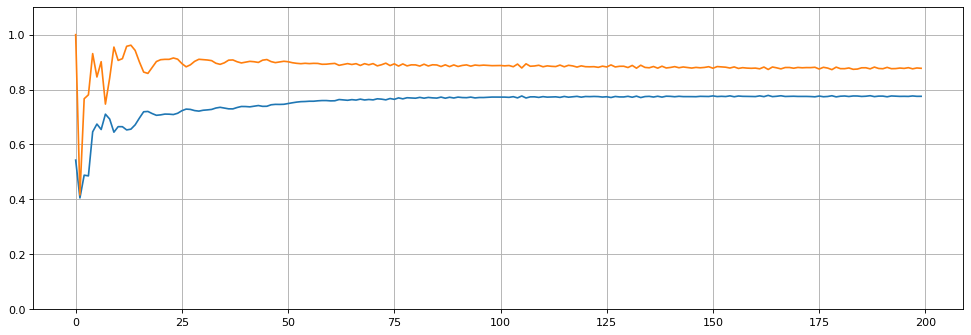

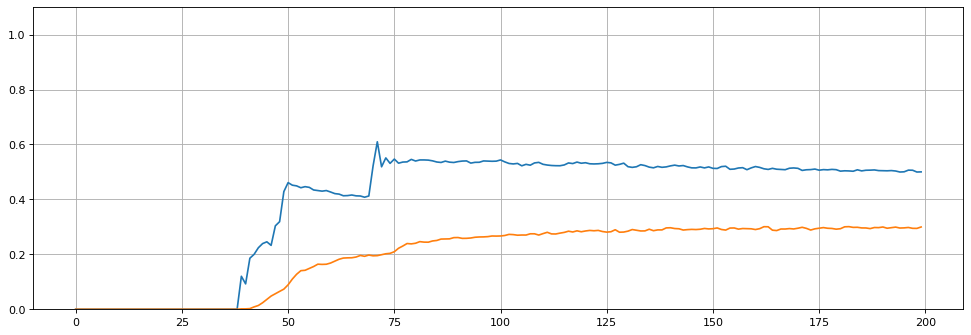

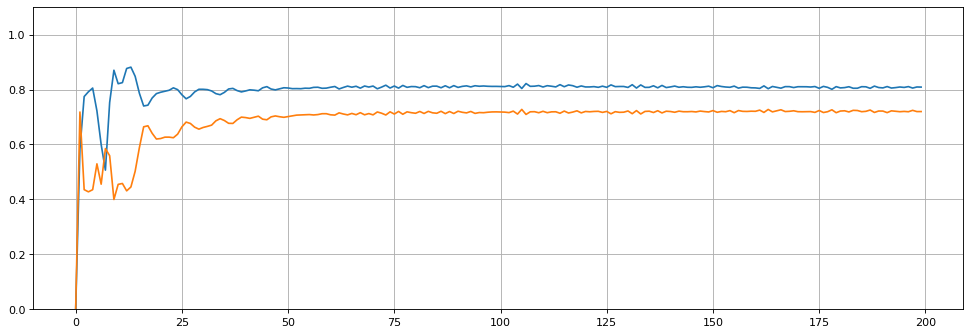

In [47]:
print("Test and Training Accuracy")
plt.figure(num =0,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([00.70,0.9])
plt.grid(which = 'both')
plt.plot(np.mean(test_plot[0:k_folds,:],axis = 0))
plt.plot(np.mean(train_plot[0:k_folds,:],axis = 0))

print("Precision and Recall for ")
plt.figure(num =1,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.0,1.1])
plt.grid(which = 'both')
plt.plot(np.mean(precision_plot0[0:k_folds,:],axis = 0))
plt.plot(np.mean(recall_plot0[0:k_folds,:],axis = 0))

plt.figure(num =2,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.0,1.1])
plt.grid(which = 'both')
plt.plot(np.mean(precision_plot1[0:k_folds,:],axis = 0))
plt.plot(np.mean(recall_plot1[0:k_folds,:],axis = 0))

plt.figure(num =3,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.0,1.1])
plt.grid(which = 'both')
plt.plot(np.mean(precision_plot2[0:k_folds,:],axis = 0))
plt.plot(np.mean(recall_plot2[0:k_folds,:],axis = 0))

plt.draw()
plt.pause(0.001)


In [6]:

#Train one final time on the entire model
history = model.fit(x, y, epochs = 90, batch_size = 4096*16)


#Load the test data
x_test, test_col,data_id = load_x_test("test_set_values.csv",train_col, do_not_include, do_not_one_hot, clean_up, do_not_include_tent, do_not_include_temp)




#Make the predictions
y_pred = model.predict(x_test)
status = np.argmax(y_pred, axis = 1)
status = status.reshape(x_test.shape[0],1)
id = x_test[:,0].reshape(x_test.shape[0],1)
y_pred = np.concatenate((id,status), axis = 1)


#Format the submission
presub_id = pd.DataFrame(data_id)
presub_status = pd.DataFrame(status)
presub_status.replace({0:'functional',1:'functional needs repair',2:'non functional'}, inplace=True)
presubmission = pd.concat([presub_id,presub_status],axis = 1)
presubmission.iloc[:,0] = presubmission.iloc[:,0].astype(int)
presubmission.to_csv("submission_datadriven.csv",header = ["id", "status_group"],index = False)
print("Outputted csv file")

Epoch 1/90
59400/59400 [==============================] - 2s 30us/step - loss: 0.4899 - acc: 0.7953
Epoch 2/90
59400/59400 [==============================] - 2s 32us/step - loss: 0.4871 - acc: 0.7965
Epoch 3/90
59400/59400 [==============================] - 2s 30us/step - loss: 0.4877 - acc: 0.7968
Epoch 4/90
59400/59400 [==============================] - 2s 31us/step - loss: 0.4870 - acc: 0.7970
Epoch 5/90
59400/59400 [==============================] - 2s 30us/step - loss: 0.4852 - acc: 0.7987
Epoch 6/90
59400/59400 [==============================] - 2s 31us/step - loss: 0.4838 - acc: 0.7978
Epoch 7/90
59400/59400 [==============================] - 2s 32us/step - loss: 0.4812 - acc: 0.7996
Epoch 8/90
59400/59400 [==============================] - 2s 30us/step - loss: 0.4823 - acc: 0.7990
Epoch 9/90
59400/59400 [==============================] - 2s 33us/step - loss: 0.4811 - acc: 0.7998
Epoch 10/90
59400/59400 [==============================] - 2s 30us/step - loss: 0.4817 - acc: 0.7986

Epoch 83/90
59400/59400 [==============================] - 2s 32us/step - loss: 0.4379 - acc: 0.8148
Epoch 84/90
59400/59400 [==============================] - 2s 33us/step - loss: 0.4383 - acc: 0.8144
Epoch 85/90
59400/59400 [==============================] - 2s 33us/step - loss: 0.4378 - acc: 0.8140
Epoch 86/90
59400/59400 [==============================] - 2s 37us/step - loss: 0.4369 - acc: 0.8141
Epoch 87/90
59400/59400 [==============================] - 2s 33us/step - loss: 0.4377 - acc: 0.8130
Epoch 88/90
59400/59400 [==============================] - 2s 33us/step - loss: 0.4368 - acc: 0.8141
Epoch 89/90
59400/59400 [==============================] - 2s 32us/step - loss: 0.4370 - acc: 0.8138
Epoch 90/90
59400/59400 [==============================] - 2s 32us/step - loss: 0.4357 - acc: 0.8149


C:\Users\Marcus\197_proj1\CoE197Z\sixfunctions.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_recorded'][i] = int(data['date_recorded'][i].replace("-","")[2:6])


Expanded basin Change 23 32
Expanded region_code Change 32 58
Expanded district_code Change 58 78
Expanded public_meeting Change 78 80
Expanded scheme_management Change 80 91
Expanded permit Change 91 93
Expanded extraction_type_class Change 93 100
Expanded management Change 100 112
Expanded management_group Change 112 117
Expanded payment_type Change 117 124
Expanded water_quality Change 124 132
Expanded quality_group Change 132 138
Expanded quantity Change 138 143
Expanded source Change 143 153
Expanded source_class Change 153 156
Expanded waterpoint_type Change 156 163
Included region_code_40.0
Included scheme_management_None
Outputted csv file
